# Behavioral Guided Single-Cell Transcriptomics Analysis (Part 4)
<span style="font-size:0.85em;">Written by: Farid Keramati (13 Feb 2024) - Last Update: Farid Keramati (8 Mar 2024)</span>

## Clustering of Dynamic Genes Along The Trajectory
&#10071;<b>Note:</b> Before runnig this analysis workflow, either make sure you have already run the previous parts of the analysis workflow (parts 1-3), or you have downloaded corresponding Seurat objects and gene lists from Zenodo depository and have them in the current working directory.

<div class="alert alert-block alert-warning">
&#9888;<b>Warning:</b> Based on different factors such as your operating system, R version, Seurat and other package versions the analysis results of different sections can be slightly different. However, major conclusions should not change. If you want to reproduce downstream analysis exactly same, please use the provided Seurat objects in <a><b>Zenodo</b></a> depository.
</div>

&nbsp;

This workflow aims to cluster dynamic genes along the trajectory (identified as the result of running previous part of the whole analysis pipeline) into categories of genes with highly similar behaviour. For this purpose we will conduct a two step clustering, mainly using kmean clustering. The overview of the analysis pipeline is as follows:<br/>
<details><summary><b>1. Read Seurat Objects and Dynamic Genes</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1. Load Required Libraries<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2. Read RDS Files<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.3. Get Expression Data for Dynamic Genes<br/>
</details>
<details><summary><b>2. First (Coarse) Clustering of Dynamic Genes</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1. Heatmap Visualize of All Dynamic Genes<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2. Cluster Genes Using Kmeans Clustering<br/>
</details>
<details><summary><b>3. Investigate Initial Clusters</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 Investigate Cluster 1 Genes<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 Investigate Cluster 2 Genes<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 Investigate Cluster 3 Genes<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4 Identify Mixed Behavior Genes<br/>
</details>
<details><summary><b>4. Second (Fine) Clustering of Dynamic Genes</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1 Kmeans Clustering of Genes with Same Behavior for All TEG Subtypes<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.2 Kmeans Clustering of Mixed Behavior Genes<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.3 Merge Similar Clusters of Mixed Behavior Genes<br/>
</details>
<details><summary><b>5. Visualize and Save Clustering Results</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1 Get Order of Genes for Each Cluster<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2 Heatmap Visualization of Behavioral Guided Clustering Results<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3 Save Clustered Table of Genes<br/>
</details>

&nbsp;

## 1. Read Seurat Objects and Dynamic Genes

### 1.1 Load Required Libraries
<details><summary>For the following workflow we will need <code>Seurat</code>, <code>dplyr</code>, <code>ggplot2</code>, <code>pheatmap</code>, <code>monocle3</code>, <code>ggthemes</code> and <code>openxlsx</code> libraries.
Make sure you have them installed before starting the analysis.</summary>
&nbsp;&nbsp;&nbsp;&nbsp;Use the following code to install the required packages:<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>install.packages(c("Seurat","dplyr","ggplot2","pheatmap","ggthemes","openxlsx","devtools"))</code><br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>devtools::install_github('cole-trapnell-lab/monocle3')</code><br/>
</details>

In [ ]:
suppressMessages(library(Seurat))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(pheatmap))
suppressMessages(library(monocle3))
suppressMessages(library(ggthemes))
suppressMessages(library(openxlsx))

### 1.2 Read RDS Files

<details><summary>Before you start, make sure that you have the data in the current working directory.</summary>
    &nbsp;&nbsp;&nbsp;&nbsp;To set the working directory use the following code:<br/>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>setwd("path to the derised folder")</code><br/>
    &nbsp;&nbsp;&nbsp;&nbsp;Otherwise you need to provide the path to the file you want to read in.
</details>

The following Seurat objects and gene lists are the results of the previous steps of the analysis workflow.

In [2]:
cd8 = readRDS("CD8_MNN_Seurat.rds")
cd4_1 = readRDS("CD4_IL17RBNeg_MNN_Seurat.rds")
cd4_2 = readRDS("CD4_IL17RBPos_MNN_Seurat.rds")

cd8_tbl = readRDS("CD8_Dynamic_Genes.rds")
cd4_tbl_1 = readRDS("CD4_IL17RBNeg_Dynamic_Genes.rds")
cd4_tbl_2 = readRDS("CD4_IL17RBPos_Dynamic_Genes.rds")

all_genes = union(union(cd8_tbl, cd4_tbl_1), cd4_tbl_2)

### 1.3 Get Expression Data for Dynamic Genes
First we extract the normalized single-cell gene expression data for all dynamic genes from each of TEG subsets and order them according to the calculated pseudotime value for each cell.<br/> 
Then, we will scale the data to have the maximum gene expression value for each gene in each TEG subset equal to 1.<br/>

In [3]:
tmp = GetAssayData(cd8, slot = "data")
pseudo = cd8$Pseudotime
pseudo = sort(pseudo, decreasing = F)
tbl_cd8 = tmp[all_genes, names(pseudo)]
tmp = GetAssayData(cd4_1, slot = "data")
pseudo = cd4_1$Pseudotime
pseudo = sort(pseudo, decreasing = F)
tbl_cd4_1 = tmp[all_genes, names(pseudo)]
tmp = GetAssayData(cd4_2, slot = "data")
pseudo = cd4_2$Pseudotime
pseudo = sort(pseudo, decreasing = F)
tbl_cd4_2 = tmp[all_genes, names(pseudo)]

# Scale all data to the max value of each cell type
row_max = apply(tbl_cd8, 1, max)
tbl_cd8 = tbl_cd8 / row_max
row_max = apply(tbl_cd4_1, 1, max)
tbl_cd4_1 = tbl_cd4_1 / row_max
row_max = apply(tbl_cd4_2, 1, max)
tbl_cd4_2 = tbl_cd4_2 / row_max
tbl_cd8[is.na(tbl_cd8)] = 0
tbl_cd4_1[is.na(tbl_cd4_1)] = 0
tbl_cd4_2[is.na(tbl_cd4_2)] = 0

&nbsp;

## 2. First (Coarse) Clustering of Dynamic Genes
### 2.1 Heatmap Visualize of All Dynamic Genes
In order to get a notion about the clustering of genes along the pseudotime trajectory we first visualize all dynamic genes along the trajectory using a heatmap. This heatmap will guide us to decide about the initial number of clusters we will use to group genes.
<div class="alert alert-block alert-warning">
&#9888;<b>Warning:</b> Based on the number of single-cells and dynamic genes generating heatmap can take a long time and it is important to have enough memory to accomodate the resulting plot. In the case of memory crash or if it takes too long to render the plot, you may want to downsample your table or visualize the heatmap for each TEG subtype separately.
</div>

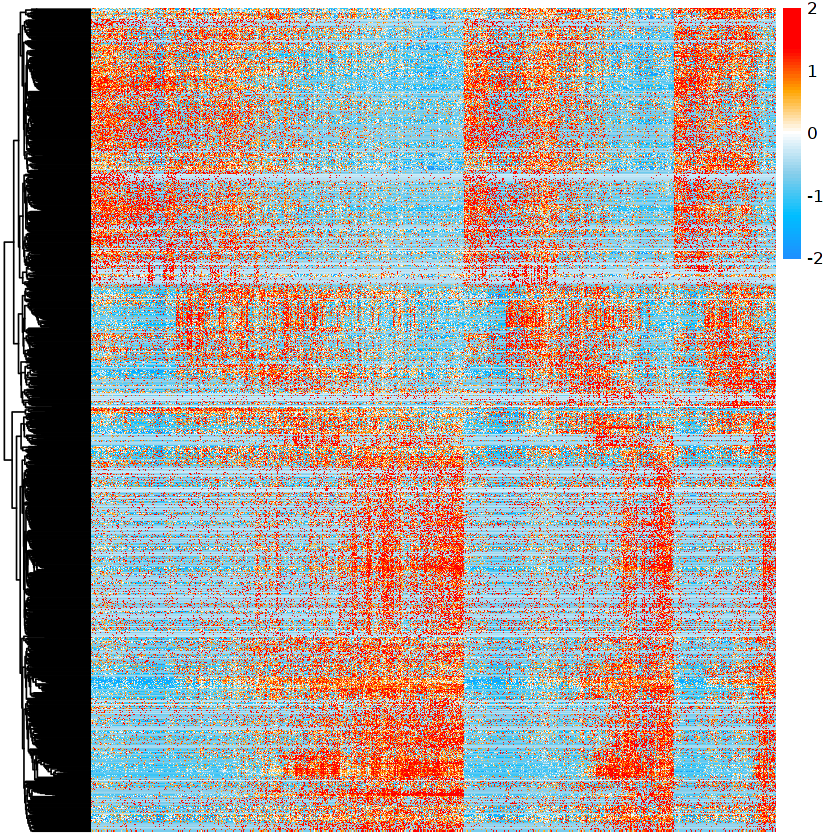

In [4]:
tbl_all = cbind(tbl_cd8, tbl_cd4_1, tbl_cd4_2)

breakslist = seq(from=-2,to=2,by=0.05)
colors = colorRampPalette(c("dodgerblue","deepskyblue","skyblue","white","orange","red","red"))(length(breakslist))
pheatmap(tbl_all, cluster_cols=F, show_rownames=F, show_colnames=F,
         scale="row", color=colors, breaks = breakslist)

### 2.2 Cluster Genes Using Kmeans Clustering
From the above results it is apparent that we have 3 main behavioral clusters along the pseudotime trajectory.<br/>
1. The group of genes having high gene expression values at the beginning of pseudotime trajectory and lose expression over the pseudotime.
2. The group of genes having highest gene expression values in the middle of pseudotime trajectory.
3. The group of genes gaining highest gene expresssion values near the end of pseudotime trajectory.

According to this, using <b>"kmeans clustering"</b> we will group genes into three main (initial) clusters.

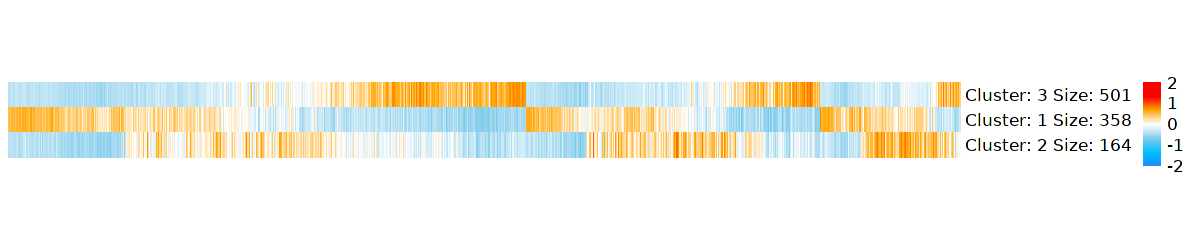

In [5]:
options(repr.plot.width=10, repr.plot.height=2)
set.seed = 1234
p = pheatmap(tbl_all, show_rownames=T, show_colnames=F, cluster_cols=F, scale="row", color=colors, cellheight=15,
             breaks=breakslist, treeheight_row=0, kmeans_k=3)

&#10071;<b>Note:</b> The results of this part can be different each time you run it (number of genes in each cluster should be the same, but the ordering of clusters can be different.) Besure to assign the right cluster number based on the behavior (for example highest expression at the beginning should be cls1).

In [6]:
cls1 = tbl_all[p$kmeans$cluster == 1,] # Highest expression at the beginning
cls2 = tbl_all[p$kmeans$cluster == 2,] # Middle induction
cls3 = tbl_all[p$kmeans$cluster == 3,] # Late induction

&nbsp;

## 3. Investigate Initial Clusters
Now that we have 3 initial clusters, we will investigate them separately to identify genes that do not belong to their corresponding clusters and need finer clustering.

<div class="alert alert-info">
<b>Note:</b> The initial clustering of dynamic genes can be sufficient for most scientific purposes and you may use the coarse clustering results. However, finer clustering will give you more clusters that might be informative.</div>

### 3.1 Investigate Cluster 1 Genes
In this step, we will investigate genes grouped as <b><u>cluster 1</u></b>, to make sure all of them classified correctly.<br/>
We will visualize genes (10 by 10) in separate plots for each TEG subtype and by manual curation, only keep those genes that have the same behaviour over the pseudotime for all three subtypes of TEGs.<br/><br/>
As an example, as you can see in the following plot, the behavior of "FAM102A" is similar for all TEG subtypes (it has highest expression at the beginning of pseudotime and loses expression in the later pseudotime values). This is while the behavior of "GNLY" is subtype-specific (while it has relatively similar behavior in CD8+ and CD4+IL17RB- cell with initial gain in expression followed by loss of expression and getting it again near the end of pseudotime, CD4+IL17RB+ cells never get the last stage increase in expression values.)<br/>
In this regard, we will exclude GNLY from the gene list of cluster 1 and will take care of it in a separate cluster, which we call <b>mixed</b> cluster, as it only contains genes with TEG subtype-specific behavior (mixed behavior).

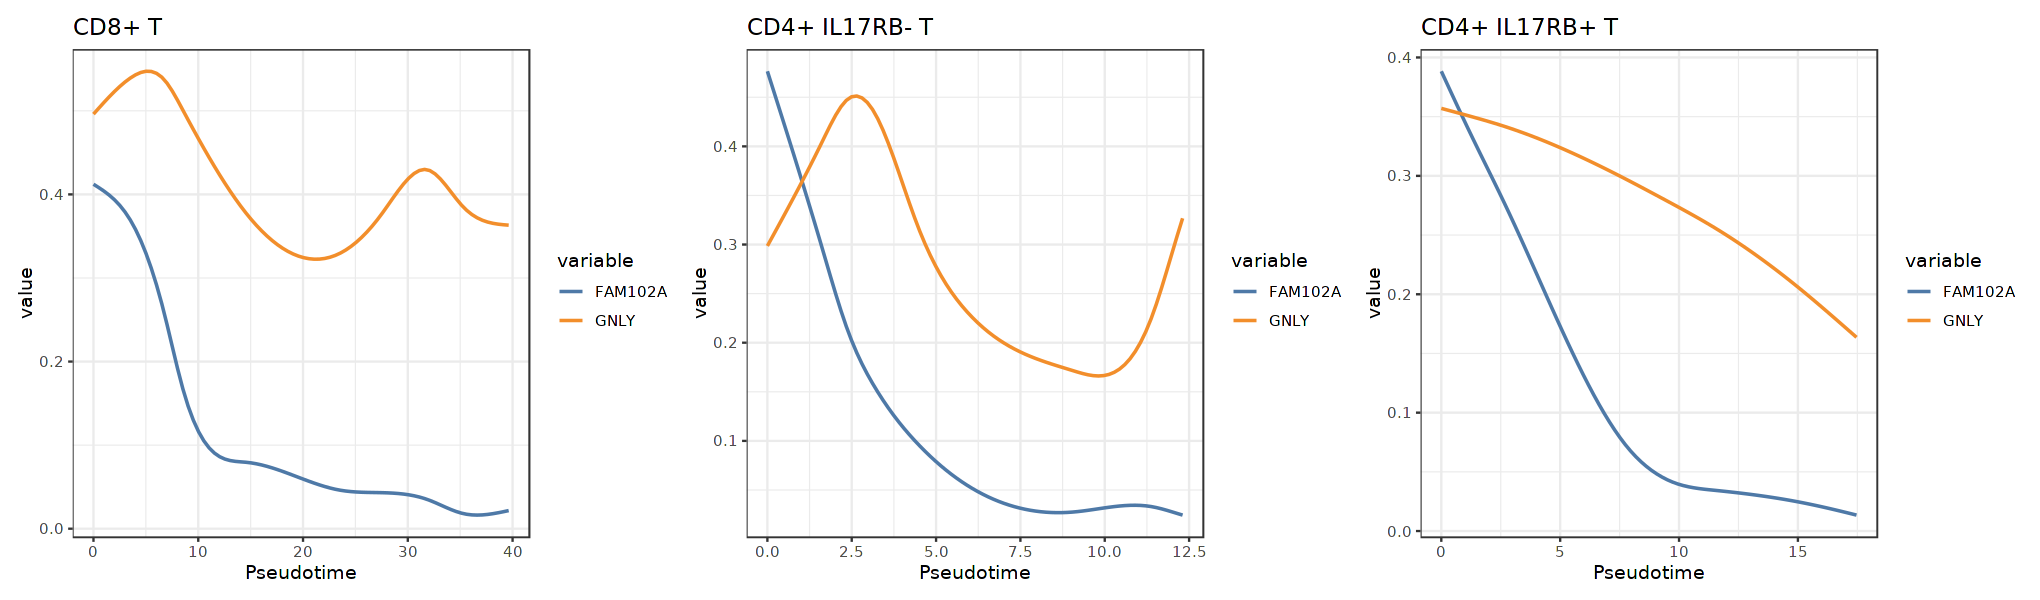

In [7]:
genes = c("FAM102A","GNLY")
options(repr.plot.width=17, repr.plot.height=5)

tmp = GetAssayData(cd8, slot="data")
pseudo = sort(cd8$Pseudotime, decreasing=F)
expr_gene = t(tmp[genes, names(pseudo)])
df_expr = data.frame(Pseudotime = pseudo, Cluster = cd8$Engagement[names(pseudo)])
df_expr = cbind(df_expr, expr_gene)
col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
mel1 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

tmp = GetAssayData(cd4_1, slot="data")
pseudo = sort(cd4_1$Pseudotime, decreasing=F)
expr_gene = t(tmp[genes, names(pseudo)])
df_expr = data.frame(Pseudotime = pseudo, Cluster = cd4_1$Engagement[names(pseudo)])
df_expr = cbind(df_expr, expr_gene)
col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
mel2 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

tmp = GetAssayData(cd4_2, slot="data")
pseudo = sort(cd4_2$Pseudotime, decreasing=F)
expr_gene = t(tmp[genes, names(pseudo)])
df_expr = data.frame(Pseudotime = pseudo, Cluster = cd4_2$Engagement[names(pseudo)])
df_expr = cbind(df_expr, expr_gene)
col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
mel3 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

p1 = ggplot(mel1) + ggtitle("CD8+ T") + theme(plot.title = element_text(hjust = 0.5)) + 
     theme_bw() + scale_color_tableau() +
     geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
p2 = ggplot(mel2) + ggtitle("CD4+ IL17RB- T") + theme(plot.title = element_text(hjust = 0.5)) + 
     theme_bw() + scale_color_tableau() +
     geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
p3 = ggplot(mel3) + ggtitle("CD4+ IL17RB+ T") + theme(plot.title = element_text(hjust = 0.5)) + 
     theme_bw() + scale_color_tableau() +
     geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
    
p1 + p2 + p3

<br/>
Using the same strategy, we investigate all genes in cluster 1 and identify genes with mixed behavior for exclusion from cluster 1 and further classification in next steps.

&#11093; <b>Caution:</b> The following code generates a relatively big pdf file with a plot for every 10 gene in cluster 1.

In [8]:
pdf(file = "LinePlot_Cluster1_Genes.pdf", width=17, height=5)

for (i in 1:((as.integer(nrow(cls1)/10))+1)){
    genes = rownames(cls1)[((i-1)*10+1):(i*10)]
    genes = genes[!is.na(genes)]
    
    if (length(genes) != 1){
        tmp = GetAssayData(cd8, slot="data")
        pseudo = sort(cd8$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd8$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel1 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        tmp = GetAssayData(cd4_1, slot="data")
        pseudo = sort(cd4_1$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd4_1$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel2 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        tmp = GetAssayData(cd4_2, slot="data")
        pseudo = sort(cd4_2$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd4_2$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel3 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        p1 = ggplot(mel1) + ggtitle("CD8+ T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
        p2 = ggplot(mel2) + ggtitle("CD4+ IL17RB- T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
        p3 = ggplot(mel3) + ggtitle("CD4+ IL17RB+ T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
    
        print(p1 + p2 + p3)  
    }
}

dev.off()

png 
  2

### 3.2 Investigate Cluster 2 Genes
In this step, we will investigate genes grouped as <b><u>cluster 2</u></b>, to make sure all of them classified correctly.<br/>
We will visualize genes (10 by 10) in separate plots for each TEG subtype and by manual curation, only keep those genes that have the same behaviour over the pseudotime for all three subtypes of TEGs.<br/><br/>

Like before, we take the same strategy to visualize genes and take out the genes with mixed behavior for each TEG subtype.

&#11093; <b>Caution:</b> The following code generates a relatively big pdf file with a plot for every 10 gene in cluster 1.

In [9]:
pdf(file = "LinePlot_Cluster2_Genes.pdf", width=17, height=5)

for (i in 1:((as.integer(nrow(cls2)/10))+1)){
    genes = rownames(cls2)[((i-1)*10+1):(i*10)]
    genes = genes[!is.na(genes)]
    
    if (length(genes) != 1){
        tmp = GetAssayData(cd8, slot="data")
        pseudo = sort(cd8$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd8$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel1 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        tmp = GetAssayData(cd4_1, slot="data")
        pseudo = sort(cd4_1$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd4_1$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel2 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        tmp = GetAssayData(cd4_2, slot="data")
        pseudo = sort(cd4_2$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd4_2$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel3 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        p1 = ggplot(mel1) + ggtitle("CD8+ T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
        p2 = ggplot(mel2) + ggtitle("CD4+ IL17RB- T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
        p3 = ggplot(mel3) + ggtitle("CD4+ IL17RB+ T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
    
        print(p1 + p2 + p3)  
    }
}

dev.off()

png 
  2

### 3.3 Investigate Cluster 3 Genes
In this step, we will investigate genes grouped as <b><u>cluster 3</u></b>, to make sure all of them classified correctly.<br/>
We will visualize genes (10 by 10) in separate plots for each TEG subtype and by manual curation, only keep those genes that have the same behaviour over the pseudotime for all three subtypes of TEGs.<br/><br/>

Like before, we take the same strategy to visualize genes and take out the genes with mixed behavior for each TEG subtype.

&#11093; <b>Caution:</b> The following code generates a relatively big pdf file with a plot for every 10 gene in cluster 1.

In [ ]:
pdf(file = "LinePlot_Cluster3_Genes.pdf", width=17, height=5)

for (i in 1:((as.integer(nrow(cls3)/10))+1)){
    genes = rownames(cls3)[((i-1)*10+1):(i*10)]
    genes = genes[!is.na(genes)]
    
    if (length(genes) != 1){
        tmp = GetAssayData(cd8, slot="data")
        pseudo = sort(cd8$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd8$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel1 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        tmp = GetAssayData(cd4_1, slot="data")
        pseudo = sort(cd4_1$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd4_1$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel2 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        tmp = GetAssayData(cd4_2, slot="data")
        pseudo = sort(cd4_2$Pseudotime, decreasing=F)
        expr_gene = t(tmp[genes, names(pseudo)])
        df_expr = data.frame(Pseudotime = pseudo, Cluster = cd4_2$Engagement[names(pseudo)])
        df_expr = cbind(df_expr, expr_gene)
        col_maxs = apply(df_expr[,3:ncol(df_expr)], 2, max)
        for (i in 3:ncol(df_expr)){df_expr[,i] = df_expr[,i] / col_maxs[i-2]}
        mel3 = reshape2::melt(df_expr, id.vars = c("Pseudotime", "Cluster"))

        p1 = ggplot(mel1) + ggtitle("CD8+ T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
        p2 = ggplot(mel2) + ggtitle("CD4+ IL17RB- T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
        p3 = ggplot(mel3) + ggtitle("CD4+ IL17RB+ T") + theme(plot.title = element_text(hjust = 0.5)) + 
         theme_bw() + scale_color_tableau() +
         geom_smooth(aes(x=Pseudotime, y=value, color=variable), method="gam", se=F, size=0.75, formula=y~s(x, bs="cs"))
    
        print(p1 + p2 + p3)  
    }
}

dev.off()

### 3.4 Identify Mixed Behavior Genes
As discussed before, using manual investigation of dynamic genes behavior over the pseudotime for each TEG subtype, we identify those genes that have subtype-specific behavior and make a list of those genes, and exclude them from initial clusters.

In [11]:
genes = c("FYN", "GSPT1", "ID2", "AKAP13", "XCL1", "TAGAP", "IRF8", "GPR18", "CRTAM", "XCL2",
          "SLAMF7", "PRF1", "CD160", "SNTB2", "LAG3", "FAM3C", "BACH2", "CD55", 
          "TPRG1", "AMIGO2", "POLR3C", "SLAMF1", "ARHGEF3", "NCEH1", "ATP1B1", "LRIG1", "BCL2L11",
          "UBASH3B", "PRKD3", "MYO1E", "IGF2R", "DSTYK", "AFAP1L2", "PAPOLA", "CHD4", "GBP2", 
          "XIRP1", "PGAM1", "KLF10", "CCL1", "IL3", "TBC1D4", "VCL", "NFATC1", "SLC29A1", "EMP1",
          "FBXO30", "ZNF593", "PA2G4", "HMGA1", "LARP1", "LRPPRC", "RPIA", "HPCAL1", "DDX55", 
          "BZW2", "IARS", "PSMG1", "AIM2", "CCT3", "CDK4", "IMP4", "CAMKK2", "CCT4", "MRPL3", 
          "RUNX3", "LTA", "NDFIP2", "HEG1", "PDCD1", "TGFBR3", "PKIA", "CD40LG", "YBX1", "EIF5A",
          "C1QBP", "TRABD2A", "URB1", "BYSL", "CCL3L3", "MAP3K8", "NTRK1", "SERPINE2", "DCAF13", 
          "SQLE", "CLUH", "POLD2", "AGK", "BOP1", "CCL5", "CD8A", "CD8B", "IL10RA", 
          "ST3GAL1", "PTPRC", "GNLY", "IL7R", "SELL", "TCF7", "RACK1", "CD74", "S100A4",
          "S100A6", "ADD3", "TNFSF13B", "SPOCK2", "CD4", "DOCK8", "TMEM156", "BTG2", "PTGER4", 
          "DDX3Y", "EPAS1", "GPR171", "LYST", "PRDM1", "IL2RB", "SAMSN1", "IL17RB", "CHDH", 
          "DGKE", "NTRK2", "CCL20", "IL1A", "PFKFB3", "HS3ST1", "CD38", "AP3M2", "SYTL3", "SEC14L1")

In [12]:
all_genes2 = setdiff(all_genes, genes)
tbl_cd8 = tbl_cd8[all_genes2,]
tbl_cd4_1 = tbl_cd4_1[all_genes2,]
tbl_cd4_2 = tbl_cd4_2[all_genes2,]

tbl_all = cbind(tbl_cd8, tbl_cd4_1, tbl_cd4_2)

&nbsp;

## 4. Second (Fine) Clustering of Dynamic Genes 
### 4.1 Kmeans Clustering of Genes with Same Behavior for All TEG Subtypes
As discussed before, using manual investigation of dynamic genes behavior over the pseudotime for each TEG subtype, we identify those genes that have subtype-specific behavior and make a list of those genes, and exclude them from initial clusters.<br/>

In this step of the analysis pipeline, since some genes are excluded from dynamic genes (kept for mixed cluster investigation) we will do the clustering again using <b>"kmeans clustering</b> algorithm and group genes into the following three clusters:
1. Cluster 1: The group of genes having high gene expression values at the beginning of pseudotime trajectory and lose expression over the pseudotime.
2. Cluster 2: The group of genes having highest gene expression values in the middle of pseudotime trajectory.
3. Cluster 3: The group of genes gaining highest gene expresssion values near the end of pseudotime trajectory.

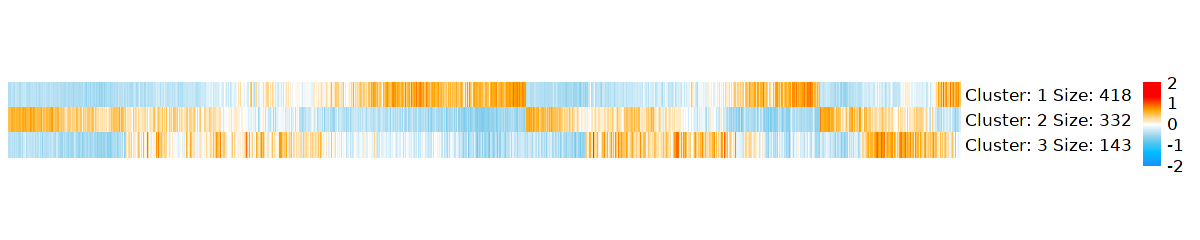

In [13]:
options(repr.plot.width=10, repr.plot.height=2)
set.seed(1234)
p = pheatmap(tbl_all, show_rownames=T, show_colnames=F, cluster_cols=F, scale="row", color=colors, cellheight=15,
             breaks=breakslist, treeheight_row=0, kmeans_k=3)

In [14]:
cls1 = tbl_all[p$kmeans$cluster==2,]
cls2 = tbl_all[p$kmeans$cluster==3,]
cls3 = tbl_all[p$kmeans$cluster==1,]

### 4.2 Kmeans Clustering of Mixed Behavior Genes
In this step, we will extract the gene expression data for the identified <b>"Mixed"</b> behavior genes and sort the gene expression table according to the calculate pseudotime.<br/>
Then, using <b>"kmeans clustering"</b> algorithm we will cluster the genes into the groups with similar behaviors over the pseudotime. For this step, we will utilize 20 (relatively high number) as the number of resulting clusters.<br/> 
Finally, as the last step, we will merge highly similar clusters into one group afterwards.

In [15]:
genes = intersect(all_genes, genes)

tmp = GetAssayData(cd8, slot = "data")
pseudo = cd8$Pseudotime
pseudo = sort(pseudo, decreasing = F)
tbl_cd8 = tmp[as.character(genes), names(pseudo)]
tmp = GetAssayData(cd4_1, slot = "data")
pseudo = cd4_1$Pseudotime
pseudo = sort(pseudo, decreasing = F)
tbl_cd4_1 = tmp[genes, names(pseudo)]
tmp = GetAssayData(cd4_2, slot = "data")
pseudo = cd4_2$Pseudotime
pseudo = sort(pseudo, decreasing = F)
tbl_cd4_2 = tmp[genes, names(pseudo)]

# Scale all data to the max value of each cell type
row_max = apply(tbl_cd8, 1, max)
tbl_cd8 = tbl_cd8 / row_max
row_max = apply(tbl_cd4_1, 1, max)
tbl_cd4_1 = tbl_cd4_1 / row_max
row_max = apply(tbl_cd4_2, 1, max)
tbl_cd4_2 = tbl_cd4_2 / row_max
tbl_cd8[is.na(tbl_cd8)] = 0
tbl_cd4_1[is.na(tbl_cd4_1)] = 0
tbl_cd4_2[is.na(tbl_cd4_2)] = 0


tbl_cd8 = tbl_cd8[genes,]
tbl_cd4_1 = tbl_cd4_1[genes,]
tbl_cd4_2 = tbl_cd4_2[genes,]

tbl_all = cbind(tbl_cd8, tbl_cd4_1, tbl_cd4_2)

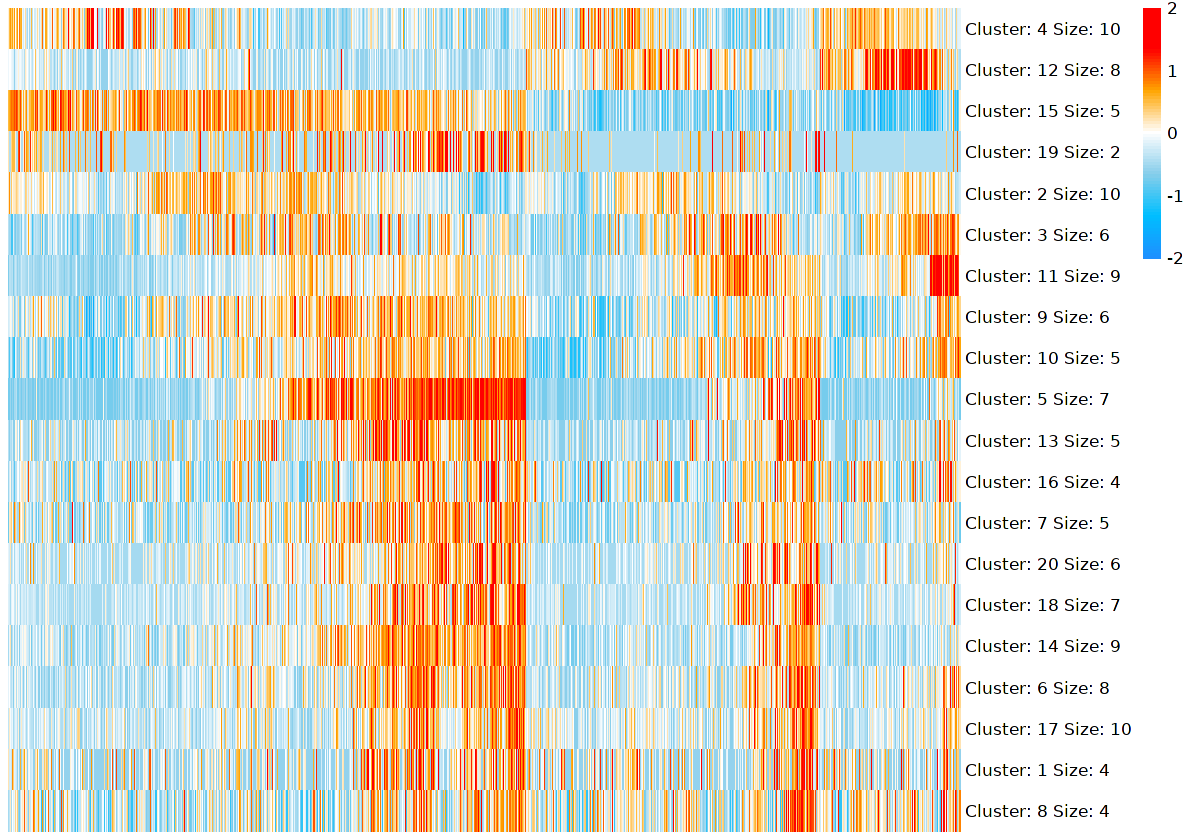

In [16]:
options(repr.plot.width=10, repr.plot.height=7)
set.seed(1234)
p = pheatmap(tbl_all, show_rownames = T, show_colnames = F, cluster_cols = F, scale = "row", color = colors,
             breaks = breakslist, treeheight_row = 0, kmeans_k = 20)

### 4.3 Merge Similar Clusters of Mixed Behavior Genes
After over-clustering mixed genes, in this step, we will merge higly similar genes into same meta-cluster. This over-clustering and secondary merging of similar clusters was intentional to have the best performance and do not skip small clusters.

In [17]:
clsM_1 = tbl_all[p$kmeans$cluster == 1,]; clsM_11 = tbl_all[p$kmeans$cluster == 11,]
clsM_2 = tbl_all[p$kmeans$cluster == 2,]; clsM_12 = tbl_all[p$kmeans$cluster == 12,]
clsM_3 = tbl_all[p$kmeans$cluster == 3,]; clsM_13 = tbl_all[p$kmeans$cluster == 13,]
clsM_4 = tbl_all[p$kmeans$cluster == 4,]; clsM_14 = tbl_all[p$kmeans$cluster == 14,]
clsM_5 = tbl_all[p$kmeans$cluster == 5,]; clsM_15 = tbl_all[p$kmeans$cluster == 15,]
clsM_6 = tbl_all[p$kmeans$cluster == 6,]; clsM_16 = tbl_all[p$kmeans$cluster == 16,]
clsM_7 = tbl_all[p$kmeans$cluster == 7,]; clsM_17 = tbl_all[p$kmeans$cluster == 17,]
clsM_8 = tbl_all[p$kmeans$cluster == 8,]; clsM_18 = tbl_all[p$kmeans$cluster == 18,]
clsM_9 = tbl_all[p$kmeans$cluster == 9,]; clsM_19 = tbl_all[p$kmeans$cluster == 19,]
clsM_10 = tbl_all[p$kmeans$cluster == 10,]; clsM_20 = tbl_all[p$kmeans$cluster == 20,]

cls4 = clsM_15
cls5 = rbind(clsM_2, clsM_4)
cls6 = rbind(clsM_3, clsM_10)
cls7 = rbind(clsM_1, clsM_5, clsM_6, clsM_7, clsM_8, clsM_9, clsM_13, clsM_14, clsM_16, clsM_17, clsM_18, clsM_19, clsM_20)
cls8 = rbind(clsM_11, clsM_12)

&nbsp;

## 5. Visualize and Save Clustering Results
### 5.1 Get Order of Genes for Each Cluster
Using the ordering (<code>cluster_rows</code>) feature of the <code>pheatmap</code> package, we get the proper ordering of genes within each cluster and make a final table of clustered gene expression values, which we will use for the heatmap visualization.

In [18]:
p = pheatmap(cls1, cluster_rows=T, cluster_cols=F, scale="row", silent=T)
cls1 = cls1[p$tree_row$order,]
p = pheatmap(cls2, cluster_rows=T, cluster_cols=F, scale="row", silent=T)
cls2 = cls2[p$tree_row$order,]
p = pheatmap(cls3, cluster_rows=T, cluster_cols=F, scale="row", silent=T)
cls3 = cls3[p$tree_row$order,]
p = pheatmap(cls4, cluster_cols=F, scale="row", cluster_rows=T, silent=T)
cls4 = cls4[p$tree_row$order,]
p = pheatmap(cls5, cluster_cols=F, scale="row", cluster_rows=T, silent=T)
cls5 = cls5[p$tree_row$order,]
p = pheatmap(cls6, cluster_cols=F, scale="row", cluster_rows=T, silent=T)
cls6 = cls6[p$tree_row$order,]
p = pheatmap(cls7, cluster_cols=F, scale="row", cluster_rows=T, silent=T)
cls7 = cls7[p$tree_row$order,]
p = pheatmap(cls8, cluster_cols=F, scale="row", cluster_rows=T, silent=T)
cls8 = cls8[p$tree_row$order,]

In [19]:
cls_all = rbind(cls1, cls2, cls3, cls4, cls5, cls6, cls7, cls8)

### 5.2 Heatmap Visualization of Behavioral Guided Clustering Results
<div class="alert alert-block alert-warning">
&#9888;<b>Warning:</b> Based on the number of single-cells and dynamic genes generating heatmap can take a long time and it is important to have enough memory to accomodate the resulting plot. In the case of memory crash or if it takes too long to render the plot, you may want to downsample your table or visualize the heatmap for each TEG subtype separately.
</div>

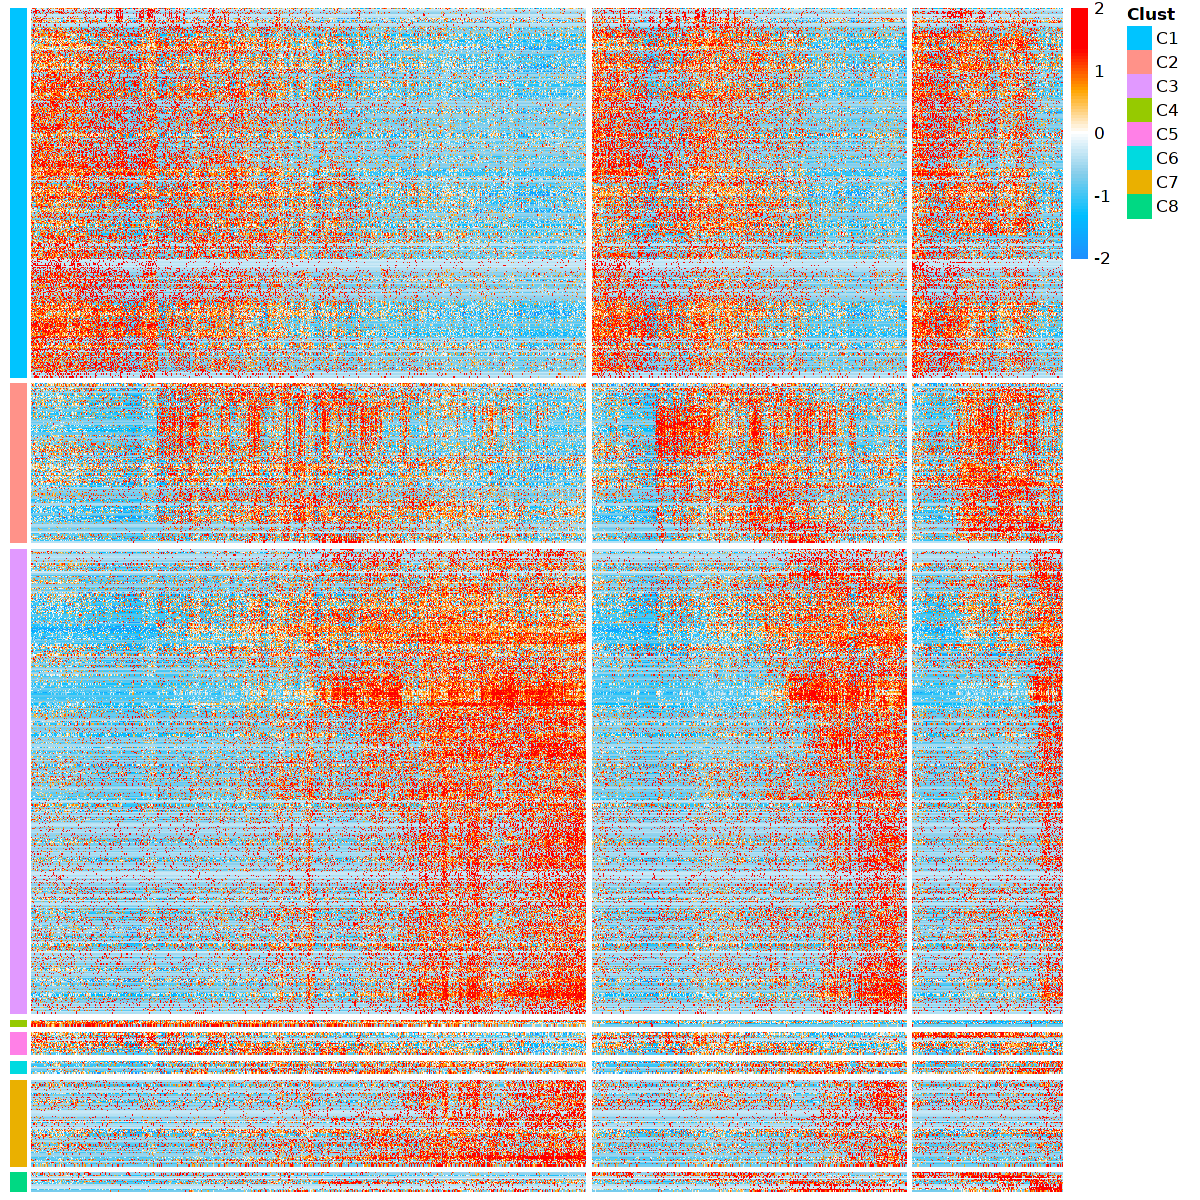

In [20]:
options(repr.plot.width=10, repr.plot.height=10)
annot_row = data.frame(Clust=c(rep("C1", 332), rep("C2", 143), rep("C3", 418), rep("C4", 5), 
                                 rep("C5", 20), rep("C6", 11), rep("C7", 77), rep("C8", 17)),
                       row.names=rownames(cls_all))

p = pheatmap(cls_all, show_rownames=F, show_colnames=F, cluster_cols=F, scale="row", cluster_rows=F,
             gaps_col=c(1805, 2827), color=colors, breaks=breakslist,
             gaps_row=c(332, 475, 893, 898, 918, 929, 1006), 
             annotation_row=annot_row, annotation_names_row=F)

### 5.3 Save Clustered Table of Genes

Finally, we save the clustering results (gene name associated with its corresponding cluster) as an Excel file.

In [21]:
df_cluster = data.frame(Gene=c(rownames(cls1), rownames(cls2), rownames(cls3), rownames(cls4), 
                                 rownames(cls5), rownames(cls6), rownames(cls7), rownames(cls8)),
                       Cluster=c(rep("C1",nrow(cls1)), rep("C2",nrow(cls2)), rep("C3",nrow(cls3)), rep("C4",nrow(cls4)),
                                   rep("C5",nrow(cls5)), rep("C6",nrow(cls6)), rep("C7",nrow(cls7)), rep("C8",nrow(cls8))))
write.xlsx(df_cluster, rowNames=F, file="Clustered_Genes_Pseudotime.xlsx")

In [22]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] openxlsx_4.2.3              ggthemes_4.2.0             
 [3] monocle3_0.2.3.0            SingleCellExperiment_1.12.0
 [5] SummarizedExperiment_1.20.0 GenomicRanges_1.42.0       
 [7] GenomeInfoDb_1.26.2         IRanges_2.24.1  